## Supplementary Figure 4

In [1]:
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import _pickle as cPickle
import os.path as path
import os
from scipy import interpolate
from scipy.optimize import curve_fit

In [2]:
from submanifolds.ringnet import Plot
from submanifolds.utils import DataManager

## Analysis

### Preamble

In [3]:
stim = 'transient'
params_to_set = {'stim': [stim],
                 'type': ['projection'],
                 }

rescale_flag = [True, False]
shift_percent = np.arange(0,0.16,.01).round(3) #np.arange(0,0.11,.01).round(2)
perc_selectivity = np.arange(0,1,0.05).round(2)
seeds = np.arange(0,10,1) 

# tuple of static parameters for referencing
static_parameters = tuple(val[0] for val in params_to_set.values())

params_to_iterate = {'rescale': rescale_flag,
                     'p_inh': perc_selectivity,
                     'seed': seeds,
                     'shift_percent': shift_percent
                     }

In [4]:
# if new experiment is run, need to fill in name of folder here!
exp_data_dir = 'subspace_exp_2025-04-15_08:53:39'

In [5]:
manage = DataManager(exp_data_dir)

In [6]:
# load an example data set to get neuron population size (N) and number of time stamps (T)
# for this experiment N and T are the same for all simulations
parameter_setting = (True, 0, 0, 0) + static_parameters
net = manage.load_data(parameter_setting)

In [7]:
N = net.params.N
T = net.params.T
n_rescale = len(rescale_flag)
n_perc_sel = len(perc_selectivity)
n_shifts = len(shift_percent)
n_seeds = len(seeds)

In [8]:
colors = ['#586ba4', '#f68e5f', '#f5dd90', '#324376', '#f76c5e', 
          '#067d7a', '#77c1b3', '#f3c759', '#ed7364', '#b63653',
          '#6d2a2a', '#361a1a', '#191414', '#465865', '#928876',
          '#fc9234', '#fd6626', '#44867d', '#177070', '#404a50']

palette = ['#C47475', '#7F9CB0'] # ['#009E92', '#7F9CB0'] #['#1D7874', '#99A88C']

In [9]:
sns.set_style('ticks')  # seaborn style
ticksize = 16           # set tick font size
labelsize = 20          # set plot label sizes

In [10]:
# Figure storage
fig_dir_supplement = manage.root + 'figures/supplementary_figures/'
if not os.path.isdir(fig_dir_supplement):
    os.mkdir(fig_dir_supplement)
    print('Created ' + fig_dir_supplement)
else:
    print(fig_dir_supplement + ' already exists')

/home/andrew/Documents/projects/submanifolds/subspace_projections_with_selective_inhibition/rate_network/figures/supplementary_figures/ already exists


In [11]:
# figure storage
fig_dir = manage.root + 'figures/supplementary_figure_4/'
if not os.path.isdir(fig_dir):
    os.mkdir(fig_dir)
    print('Created ' + fig_dir)
else:
    print('Directory already exists')
    
save_figs_flag = 1

Directory already exists


In [12]:
# scaling
rescale_val = True
rescale_ind = rescale_flag.index(rescale_val) # 0 for rescaled, 1 for not rescaled weights

# not rescaled
no_rescale_val = False
no_rescale_ind = rescale_flag.index(no_rescale_val)

# percent selective inhibition
perc_val = .6
perc_ind = np.where(perc_selectivity==perc_val)[0][0]

# no selective inhibition
no_perc_val = 0
no_perc_ind = np.where(perc_selectivity==no_perc_val)[0][0]

# shift
shift_val = 0.1
shift_ind = np.where(shift_percent==shift_val)[0][0]

# no shift
no_shift_val = 0
no_shift_ind = np.where(shift_percent==no_shift_val)[0][0]

# seed
seed_val = 0
seed_ind = np.where(seeds==seed_val)[0][0]

## Bump statistics

Here we fit a Gaussian to the activity at each time point to determine
- bump speed
- bump amplitude
- bump width

#### Activity over time

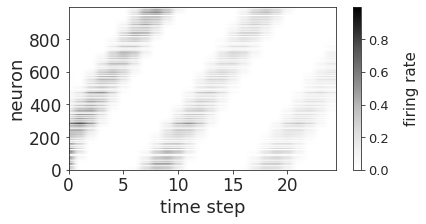

In [13]:
parameter_setting = (rescale_val, perc_val, seed_val, shift_val) + static_parameters
net = manage.load_data(parameter_setting)

plotter = Plot()
plotter.activity_raster(net.R) #, storage_loc=figure_dir+'exc_activity_raster_p=0.3,seed=6,transient,projection.pdf')

#### Activity at one time point

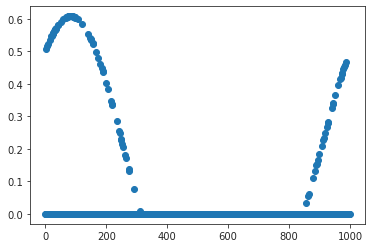

In [14]:
parameter_setting = (True, 0.8, 1, .1) + static_parameters
net = manage.load_data(parameter_setting)
R = net.R
P = net.P

t = 9
plt.figure()
plt.scatter(np.arange(0,1000,1), R[:,t])
plt.show()

### Method: fitting gaussian to bump (taking periodic boundary into account)

- concatenate the activity multiple times (e.g. 3 times, depends on sigma)
- find the peaks
- choose the first peak that is "far away enough" (e.g. 3 std or perhaps N/2 points) from each edge
- take N/2 data points on each side of this center
- the actual center is the new center mod N (but better to take center of fitted gaussian)

This still has uncertainty coming from where the center is located due to inhibited neurons. The expectation is that the center will be off proportional to the number of silenced neurons.

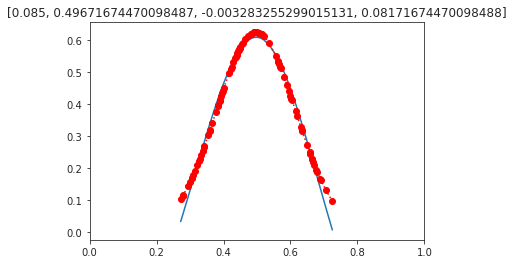

In [15]:
buffer = int(N/2)
left_bound = 0
right_bound = 3*N

def gaussian(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))


R_padded = np.concatenate([R[:,t],R[:,t],R[:,t]])
max_indices = np.where(R_padded == R_padded.max())[0]
R_argmax = max_indices[np.where((max_indices - buffer > left_bound) & (max_indices + buffer < right_bound))[0][0]]
estimated_center = R_argmax % N

x = np.arange(0,1,1/N)
y = R_padded[R_argmax-int(N/2):R_argmax+int(N/2)]

non_zero_entries = y!=0
x = x[non_zero_entries]
y = y[non_zero_entries]

n = len(x)                          #the number of data
mean = sum(x*y)/n                   #note this correction
sigma = sum(y*(x-mean)**2)/n        #note this correction

try:
    popt,pcov = curve_fit(gaussian, x, y, bounds=([0,0,0], [100, 1, 20]), maxfev=5000)
except RuntimeError:
    popt = [-10, -10, -10]
    print('didnt find solution')

discrepancy = popt[1] - .5
    
plt.figure()
plt.plot(x, y)
plt.plot(x, gaussian(x,*popt),'ro:',label='fit')
plt.title([estimated_center/N, popt[1], discrepancy, estimated_center/N + discrepancy])
plt.xlim(0,1)
plt.show()

Text(0.5, 1.0, '[  85 1085 2085]')

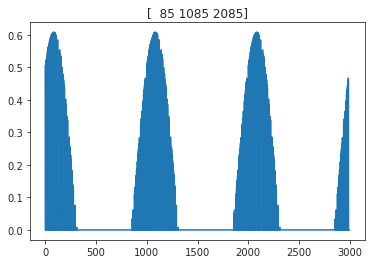

In [16]:
test = np.concatenate([R[:,t],R[:,t],R[:,t]])
plt.plot(test)
#plt.xlim(1500,1530)
#plt.ylim(1.1,1.2)
plt.title(str(np.where(test == test.max())[0]))

In [17]:
buffer = int(N/2)
max_indices = np.where(test == test.max())[0]
test_center = max_indices[np.where((max_indices - buffer > 0) & (max_indices + buffer < 3*N))[0][0]]

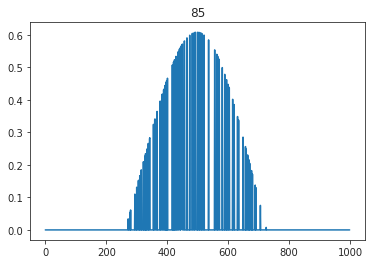

In [18]:
plt.figure()
plt.plot(test[test_center-int(N/2):test_center+int(N/2)])
plt.title(test_center % N)
plt.show()

## Analysis: fit Gaussian and get amplitude, speed, width for each simulation

In [19]:
# number of time steps starting from second timestep (remove initialization)
t_0 = 1
n_timesteps = T - t_0

buffer = int(N/2)
left_bound = 0
right_bound = 3*N

compute_activity_statistics = 0

### Compute and store / load data

In [20]:
# if true, compute and store data
if compute_activity_statistics == 1:

    # initialize arrays to store the amplitudes, centers, widths of the fitted gaussian
    amplitudes = np.zeros((n_perc_sel, n_shifts, n_seeds, n_timesteps))
    centers = np.zeros((n_perc_sel, n_shifts, n_seeds, n_timesteps))
    sigmas = np.zeros((n_perc_sel, n_shifts, n_seeds, n_timesteps))
    dist_travelled = np.zeros((n_perc_sel, n_shifts, n_seeds, n_timesteps-1))

    # normalized root mean square error, measure goodness of fit
    nrmse = np.zeros((n_perc_sel, n_shifts, n_seeds, n_timesteps))

    # defines Gaussian which we fit to the activity bump at each timestep
    def gaussian(x,a,x0,sigma):
        return a*np.exp(-(x-x0)**2/(2*sigma**2))

    # loop over percent inhibition, percent shift, and trials (i.e. seeds)
    for k, p in enumerate(perc_selectivity):
        for i, s in enumerate(shift_percent):
            for j, seed in enumerate(seeds):

                # build parameter tuple, point in parameter space
                parameter_setting = (rescale_val, p, seed, s) + static_parameters

                # load network instance belonging to that parameter setting
                net = manage.load_data(parameter_setting)

                # extract activity 
                R = net.R

                # loop through each time step to fit gaussian and extract amplitude, center, and width
                for t in range(n_timesteps):

                    # select timestep t, offset by t_0 (to skip initialization t=0)
                    t_sel = t + t_0 
                    R_padded = np.concatenate([R[:,t_sel],R[:,t_sel],R[:,t_sel]])
                    max_indices = np.where(R_padded == R_padded.max())[0]
                    R_argmax = max_indices[np.where((max_indices - buffer > left_bound) & (max_indices + buffer < right_bound))[0][0]]
                    estimated_center = R_argmax % N

                    x = np.arange(0,1,1/N)
                    y = R_padded[R_argmax-int(N/2):R_argmax+int(N/2)]

                    non_zero_entries = y!=0
                    x = x[non_zero_entries]
                    y = y[non_zero_entries]

                    #n = len(x)                          #the number of data
                    #mean = sum(x*y)/n                   #note this correction
                    #sigma = sum(y*(x-mean)**2)/n        #note this correction

                    try:
                        popt,pcov = curve_fit(gaussian, x, y, bounds=([0,0,0], [100, 1, 20]), maxfev=5000)
                    except RuntimeError:
                        popt = [-10, -10, -10]
                        print('didnt find solution')

                    # first we centered the activity around the computed argmax of firing rate distribution
                    # then we computed a gaussian fit
                    # if the original peak were the true center, we should get 0.5 for the center of the gaussian
                    # anything else is a discrepancy that we need to add back onto the original estimated center
                    discrepancy = popt[1] - 0.5

                    amplitudes[k,i,j,t] = popt[0]
                    centers[k,i,j,t] = (estimated_center/N + discrepancy) % 1  # mod 1 here since coordinates x in [0,1]
                    sigmas[k,i,j,t] = popt[2]

                    # store goodness of fit as normalised root mean square error
                    nrmse[k,i,j,t] = np.sqrt(np.sum((y - gaussian(x,*popt))**2) / len(x)) / max(y)

                    if t>0:
                        current_center = centers[k,i,j,t]
                        last_center = centers[k,i,j,t-1]
                        dist = np.abs(current_center - last_center)

                        # distance on ring, if crossing 0 then dist>0.5, so real dist is 1-dist
                        #if dist > 0.5:
                        #    dist = 1 - dist
                        dist_travelled[k,i,j,t-1] = np.minimum(dist, 1-dist)

                    print('\rCurrent setting: ' + str(parameter_setting), end='')
                
    # store data
    manage.save(amplitudes, 'amplitudes', manage.bump_dir)
    manage.save(centers, 'centers', manage.bump_dir)
    manage.save(sigmas, 'sigmas', manage.bump_dir)
    manage.save(dist_travelled, 'dist_travelled', manage.bump_dir)
    manage.save(nrmse, 'nrmse', manage.bump_dir)
    
    print('Data stored in ' + manage.bump_dir)
    
# otherwise load the data
else:
    amplitudes = manage.load('amplitudes', manage.bump_dir)
    centers = manage.load('centers', manage.bump_dir)
    sigmas = manage.load('sigmas', manage.bump_dir)
    dist_travelled = manage.load('dist_travelled', manage.bump_dir)
    nrmse = manage.load('nrmse', manage.bump_dir)
    
    print('Data loaded from ' + manage.bump_dir)

Data loaded from /home/andrew/Documents/projects/submanifolds/subspace_projections_with_selective_inhibition/rate_network/data/weight_matrix_exp_2025-04-15_08:53:39/bump_statistics/


### Bump speed

In [21]:
dist_travelled_centered = np.zeros((n_perc_sel, n_shifts, n_seeds, n_timesteps-1))
amplitudes_centered = np.zeros((n_perc_sel, n_shifts, n_seeds, n_timesteps))
sigmas_centered = np.zeros((n_perc_sel, n_shifts, n_seeds, n_timesteps))

for k, p in enumerate(perc_selectivity):
    for i, s in enumerate(shift_percent):
        for j, seed in enumerate(seeds):
            dist_travelled_centered[k,i,j,:] = (dist_travelled[k,i,j,:] - dist_travelled[0,i,j,:]) / dist_travelled[0,i,j,:]
            amplitudes_centered[k,i,j,:] = (amplitudes[k,i,j,:] - amplitudes[0,i,j,:]) / amplitudes[0,i,j,:]
            sigmas_centered[k,i,j,:] = (sigmas[k,i,j,:] - sigmas[0,i,j,:]) / sigmas[0,i,j,:]

In [22]:
avg_speed_over_time = np.mean(dist_travelled_centered, axis=3)
std_speed_over_time = np.std(dist_travelled_centered, axis=3)

mean_speed = avg_speed_over_time.mean(axis=2)
std_speed = np.sqrt((std_speed_over_time**2).mean(axis=2))

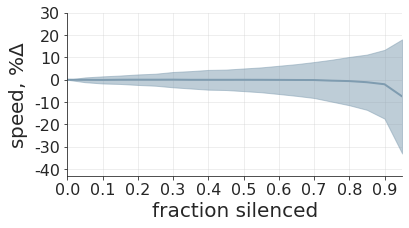

In [23]:
fig, ax = plt.subplots(figsize=(6,3))
plt.plot(perc_selectivity, mean_speed[:,shift_ind], color=palette[1], linewidth=2)
plt.fill_between(perc_selectivity,
                 mean_speed[:,shift_ind]-std_speed[:,shift_ind], 
                 mean_speed[:,shift_ind]+std_speed[:,shift_ind],
                 color=palette[1],
                 alpha=0.5
                )
#plt.xlim(0,)
plt.xlim(0,.95)
plt.ylim(-0.43,0.3)
plt.xlabel('fraction silenced', fontsize=labelsize)
plt.ylabel('speed, %$\Delta$', fontsize=labelsize)
ax.set_xticks(np.arange(0,1, 0.1))
ax.set_yticks(np.arange(-.4,.4, 0.1), np.arange(-40,40, 10))
ax.tick_params(axis='both', which='major', labelsize=ticksize)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.grid(alpha=0.4)

#if save_figs_flag:
#    plt.savefig(fig_dir+fname, bbox_inches="tight")
#    print('saved figure')
#plt.show()

In [24]:
avg_speed_over_time = np.mean(dist_travelled, axis=3)
std_speed_over_time = np.std(dist_travelled, axis=3)


# mean and std, multiply by number neurons N to get grid pts per time step
mean_speed = N * avg_speed_over_time.mean(axis=2)
std_speed = N * np.sqrt((std_speed_over_time**2).mean(axis=2))

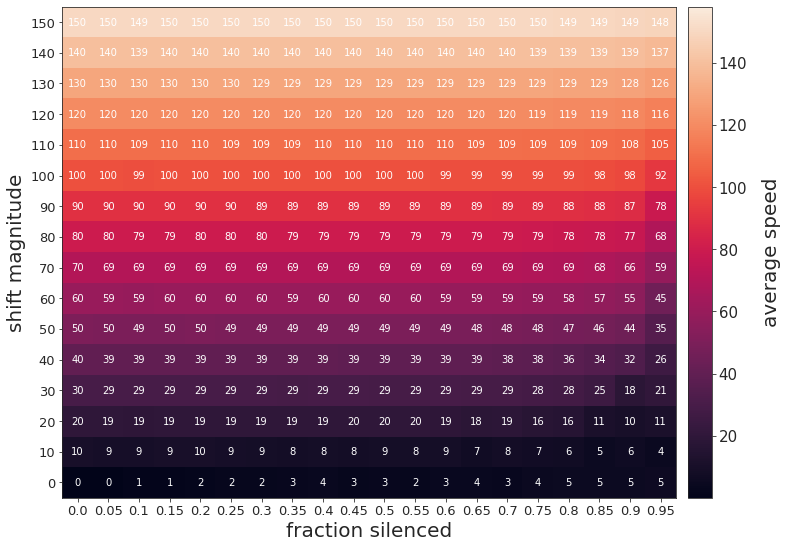

In [25]:
fname='speed_mean.pdf'

fig, ax = plt.subplots(figsize=(11,11))
im = ax.imshow(mean_speed.T, origin='lower', vmax=158)
#plt.colorbar()

plt.xlabel('fraction silenced', fontsize=labelsize)
plt.ylabel('shift magnitude', fontsize=labelsize)
#plt.xticks(np.arange(0,1, 0.1))

plt.xticks(np.arange(0,len(perc_selectivity)), perc_selectivity, fontsize=13)
plt.yticks(np.arange(0,len(shift_percent)), (1000*shift_percent).astype(int), fontsize=13)

cax = fig.add_axes([ax.get_position().x1+0.015,ax.get_position().y0,0.03,ax.get_position().height])
cb = plt.colorbar(im, cax=cax) # Similar to fig.colorbar(im, cax = cax)

cb.ax.tick_params(labelsize=15)
cb.ax.get_yaxis().labelpad = 15
cb.ax.set_ylabel('average speed', fontsize=20)

for (j,i), label in np.ndenumerate(mean_speed.T):
    ax.text(i,j,(label).astype(int),ha='center',va='center',color='white')

if save_figs_flag:
    plt.savefig(fig_dir+fname, bbox_inches="tight")
plt.show()

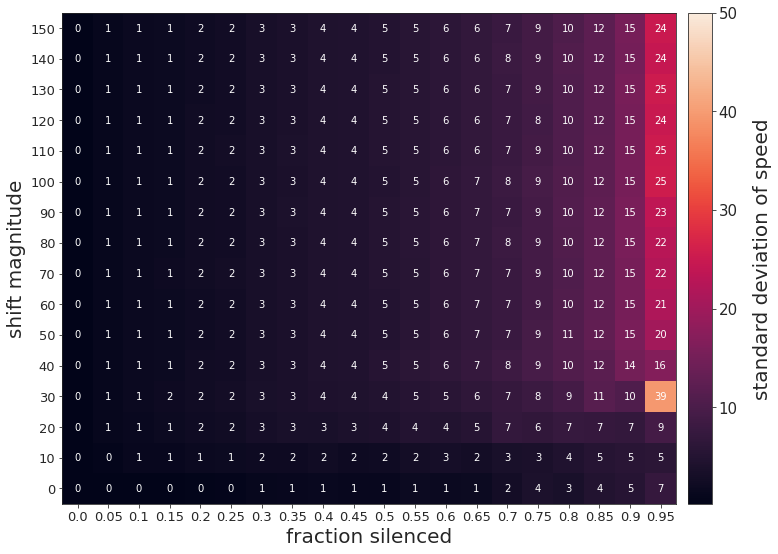

In [26]:
fname='speed_std.pdf'

fig, ax = plt.subplots(figsize=(11,11))
im = ax.imshow(std_speed.T, origin='lower', vmax=50)
#plt.colorbar()

plt.xlabel('fraction silenced', fontsize=labelsize)
plt.ylabel('shift magnitude', fontsize=labelsize)
#plt.xticks(np.arange(0,1, 0.1))

plt.xticks(np.arange(0,len(perc_selectivity)), perc_selectivity, fontsize=13)
plt.yticks(np.arange(0,len(shift_percent)), (1000*shift_percent).astype(int), fontsize=13)

cax = fig.add_axes([ax.get_position().x1+0.015,ax.get_position().y0,0.03,ax.get_position().height])
cb = plt.colorbar(im, cax=cax) # Similar to fig.colorbar(im, cax = cax)

cb.ax.tick_params(labelsize=15)
cb.ax.get_yaxis().labelpad = 15
cb.ax.set_ylabel('standard deviation of speed', fontsize=20)

for (j,i), label in np.ndenumerate(std_speed.T):
    ax.text(i,j,(label).astype(int),ha='center',va='center',color='white')

if save_figs_flag:
    plt.savefig(fig_dir+fname, bbox_inches="tight")
plt.show()

## Bump amplitude

In [27]:
avg_amplitude_over_time = np.mean(amplitudes_centered, axis=3)
std_amplitude_over_time = np.std(amplitudes_centered, axis=3)

mean_amplitude = avg_amplitude_over_time.mean(axis=2)
std_amplitude = np.sqrt((std_amplitude_over_time**2).mean(axis=2))

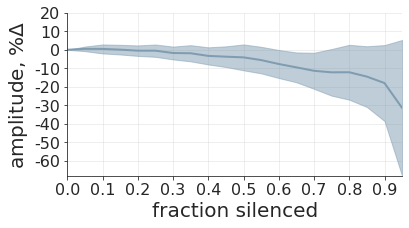

In [28]:
fig, ax = plt.subplots(figsize=(6,3))
plt.plot(perc_selectivity, mean_amplitude[:,shift_ind], color=palette[1], linewidth=2)
plt.fill_between(perc_selectivity,
                 mean_amplitude[:,shift_ind]-std_amplitude[:,shift_ind], 
                 mean_amplitude[:,shift_ind]+std_amplitude[:,shift_ind],
                 color=palette[1],
                 alpha=0.5
                )
plt.xlabel('fraction silenced', fontsize=labelsize)
plt.ylabel('amplitude, %$\Delta$', fontsize=labelsize)
ax.set_xticks(np.arange(0,1, 0.1))
ax.set_yticks(np.arange(-.7,.3, .1), np.arange(-70,30, 10))
plt.xlim(0,.95)
plt.ylim(-0.68,.2)
ax.tick_params(axis='both', which='major', labelsize=ticksize)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.grid(alpha=0.4)

#if save_figs_flag:
#    plt.savefig(fig_dir+fname, bbox_inches="tight")
#plt.show()

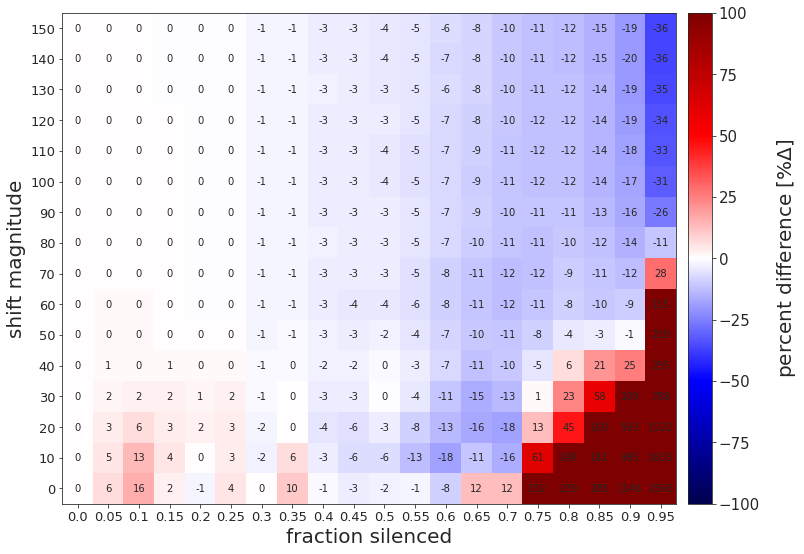

In [29]:
fname='amplitude_mean.pdf'

#scale to percentage points
mean_amplitude_percent = 100 * mean_amplitude

fig, ax = plt.subplots(figsize=(11,11))
im = ax.imshow(mean_amplitude_percent.T, cmap='seismic', origin='lower', vmin=-100, vmax=100)
#plt.colorbar()

plt.xlabel('fraction silenced', fontsize=labelsize)
plt.ylabel('shift magnitude', fontsize=labelsize)
#plt.xticks(np.arange(0,1, 0.1))

plt.xticks(np.arange(0,len(perc_selectivity)), perc_selectivity, fontsize=13)
plt.yticks(np.arange(0,len(shift_percent)), (1000*shift_percent).astype(int), fontsize=13)

cax = fig.add_axes([ax.get_position().x1+0.015,ax.get_position().y0,0.03,ax.get_position().height])
cb = plt.colorbar(im, cax=cax) # Similar to fig.colorbar(im, cax = cax)

cb.ax.tick_params(labelsize=15)
cb.ax.get_yaxis().labelpad = 15
cb.ax.set_ylabel('percent difference [%$\Delta$]', fontsize=20)

for (j,i), label in np.ndenumerate(mean_amplitude_percent.T):
    ax.text(i,j,int(label),ha='center',va='center')

if save_figs_flag:
    plt.savefig(fig_dir+fname, bbox_inches="tight")
plt.show()

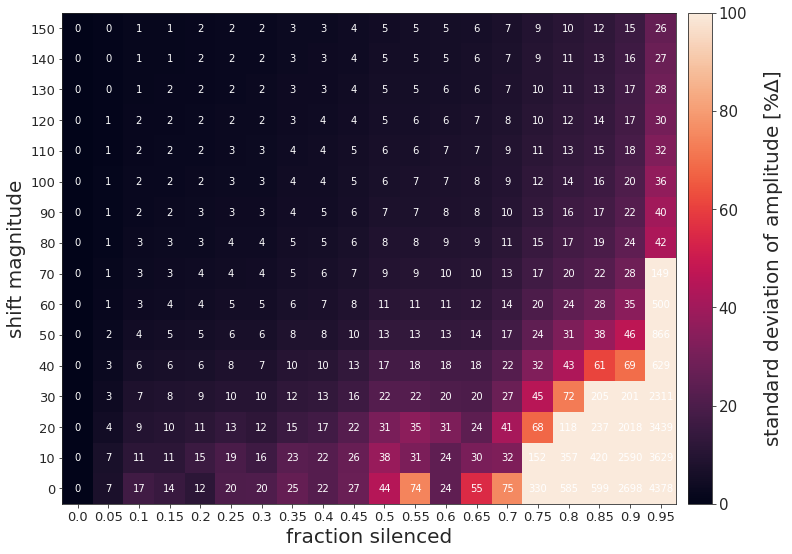

In [30]:
fname='amplitude_std.pdf'

#scale to percentage points
std_amplitude_percent = 100 * std_amplitude

fig, ax = plt.subplots(figsize=(11,11))
im = ax.imshow(std_amplitude_percent.T, origin='lower', vmin=0, vmax=100)
#plt.colorbar()

plt.xlabel('fraction silenced', fontsize=labelsize)
plt.ylabel('shift magnitude', fontsize=labelsize)
#plt.xticks(np.arange(0,1, 0.1))

plt.xticks(np.arange(0,len(perc_selectivity)), perc_selectivity, fontsize=13)
plt.yticks(np.arange(0,len(shift_percent)), (1000*shift_percent).astype(int), fontsize=13)

cax = fig.add_axes([ax.get_position().x1+0.015,ax.get_position().y0,0.03,ax.get_position().height])
cb = plt.colorbar(im, cax=cax) # Similar to fig.colorbar(im, cax = cax)

cb.ax.tick_params(labelsize=15)
cb.ax.get_yaxis().labelpad = 15
cb.ax.set_ylabel('standard deviation of amplitude [%$\Delta$]', fontsize=20)

for (j,i), label in np.ndenumerate(std_amplitude_percent.T):
    ax.text(i,j,int(label),ha='center',va='center', color='white')

if save_figs_flag:
    plt.savefig(fig_dir+fname, bbox_inches="tight")
plt.show()

## Bump width

In [31]:
avg_sigma_over_time = sigmas_centered.mean(axis=3)
std_sigma_over_time = sigmas_centered.std(axis=3)

mean_sigma = avg_sigma_over_time.mean(axis=2)
std_sigma = np.sqrt((std_sigma_over_time**2).mean(axis=2))

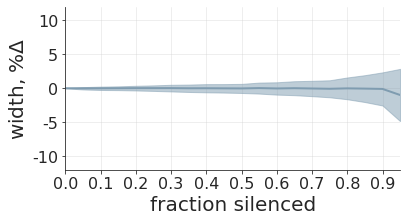

In [32]:
fig, ax = plt.subplots(figsize=(6,3))
plt.plot(perc_selectivity, mean_sigma[:,shift_ind],color=palette[1], linewidth=2)
plt.fill_between(perc_selectivity,
                 mean_sigma[:,shift_ind]-std_sigma[:,shift_ind], 
                 mean_sigma[:,shift_ind]+std_sigma[:,shift_ind],
                 color=palette[1],
                 alpha=0.5
                )
plt.xlim(0,.95)
plt.ylim(-.12, .12)
plt.xlabel('fraction silenced', fontsize=labelsize)
plt.ylabel('width, %$\Delta$', fontsize=labelsize)
ax.set_xticks(np.arange(0,1, 0.1))
ax.set_yticks(np.arange(-.1,.15, .05), np.arange(-10,15, 5))
ax.tick_params(axis='both', which='major', labelsize=ticksize)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.grid(alpha=0.4)

#if save_figs_flag:
#    plt.savefig(fig_dir+fname, bbox_inches="tight")
#plt.show()

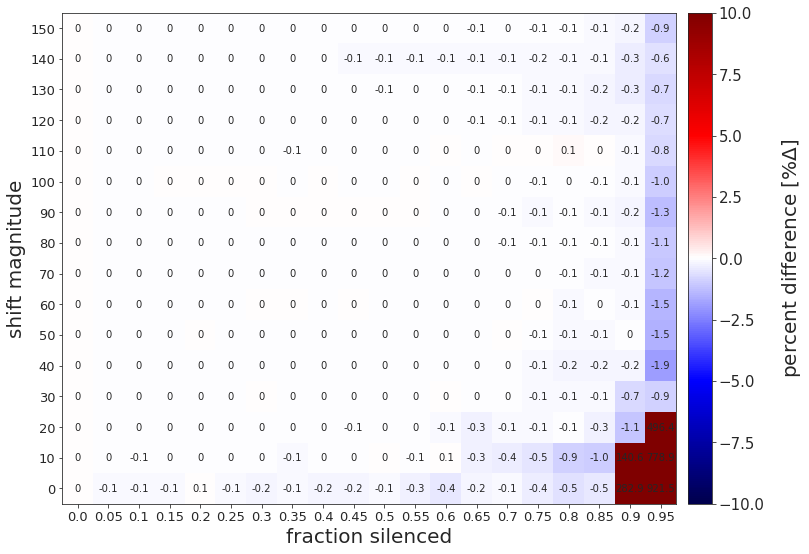

In [33]:
fname='width_mean.pdf'

#scale to percentage points
mean_sigma_percent = 100 * mean_sigma

fig, ax = plt.subplots(figsize=(11,11))
im = ax.imshow(mean_sigma_percent.T, cmap='seismic', origin='lower', vmin=-10, vmax=10)
#plt.colorbar()

plt.xlabel('fraction silenced', fontsize=labelsize)
plt.ylabel('shift magnitude', fontsize=labelsize)
#plt.xticks(np.arange(0,1, 0.1))

plt.xticks(np.arange(0,len(perc_selectivity)), perc_selectivity, fontsize=13)
plt.yticks(np.arange(0,len(shift_percent)), (1000*shift_percent).astype(int), fontsize=13)

cax = fig.add_axes([ax.get_position().x1+0.015,ax.get_position().y0,0.03,ax.get_position().height])
cb = plt.colorbar(im, cax=cax) # Similar to fig.colorbar(im, cax = cax)

cb.ax.tick_params(labelsize=15)
cb.ax.get_yaxis().labelpad = 15
cb.ax.set_ylabel('percent difference [%$\Delta$]', fontsize=20)

for (j,i), label in np.ndenumerate(mean_sigma_percent.T):
    val = label.round(1)
    if abs(val) < 0.1: # this prevents -0.0 from showing up on plot
        val = 0
    ax.text(i,j, val, ha='center',va='center')

if save_figs_flag:
    plt.savefig(fig_dir+fname, bbox_inches="tight")
plt.show()

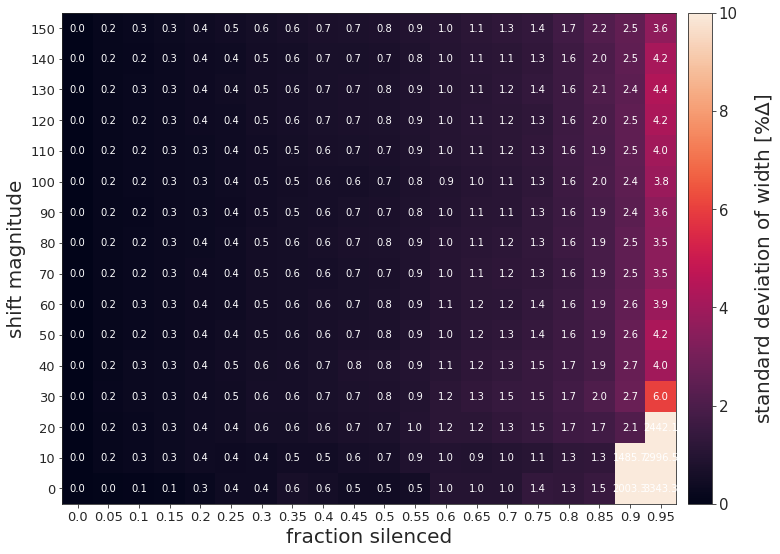

In [34]:
fname='width_std.pdf'

#scale to percentage points
std_sigma_percent = 100 * std_sigma

fig, ax = plt.subplots(figsize=(11,11))
im = ax.imshow(std_sigma_percent.T, origin='lower', vmin=0, vmax=10)
#plt.colorbar()

plt.xlabel('fraction silenced', fontsize=labelsize)
plt.ylabel('shift magnitude', fontsize=labelsize)
#plt.xticks(np.arange(0,1, 0.1))

plt.xticks(np.arange(0,len(perc_selectivity)), perc_selectivity, fontsize=13)
plt.yticks(np.arange(0,len(shift_percent)), (1000*shift_percent).astype(int), fontsize=13)

cax = fig.add_axes([ax.get_position().x1+0.015,ax.get_position().y0,0.03,ax.get_position().height])
cb = plt.colorbar(im, cax=cax) # Similar to fig.colorbar(im, cax = cax)

cb.ax.tick_params(labelsize=15)
cb.ax.get_yaxis().labelpad = 15
cb.ax.set_ylabel('standard deviation of width [%$\Delta$]', fontsize=20)

for (j,i), label in np.ndenumerate(std_sigma_percent.T):
    ax.text(i,j, label.round(1), ha='center',va='center',color='white')

if save_figs_flag:
    plt.savefig(fig_dir+fname, bbox_inches="tight")
plt.show()